# Requirements

In [1]:
!pip install tensorflow-datasets

In [2]:
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow import keras
# import larq as lq
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.layers import *
from keras.utils import np_utils
import matplotlib.pyplot as plt

Using TensorFlow backend.


> # Get Oxford pet dataset dataset from tf datasets

In [3]:
train_data, info_1 = tfds.load(name="oxford_iiit_pet:3.0.0", split="train",with_info=True) 
test_data, info_2 = tfds.load(name="oxford_iiit_pet:3.0.0", split="test",with_info=True)


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteOMJLGA/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteOMJLGA/oxford_iiit_pet-test.tfrecord


Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.



Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.0.0. Subsequent calls will reuse this data.


In [0]:
def normalize_data(data_val):
    
    image = data_val['image']
    mask = data_val['segmentation_mask']
    image = tf.image.resize(image, (128, 128))
    mask = tf.image.resize(mask, (128, 128))
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # Change mask vals to [0,1,2]
    mask -= 1
    return image, mask

In [0]:
def data_augmentation(data_val):
    
    #Normalize both training and testing images
   
    image, mask = normalize_data(data_val)
    #Augmentation only for training
    if tf.random.uniform(()) > 0.5:
        #Apply to both image and maska
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
  
    
    return image, mask

In [6]:
print("Training samples: {} \nTest samples: {} ".format(info_1.splits['train'].num_examples,info_2.splits['test'].num_examples))

Training samples: 3680 
Test samples: 3669 


In [0]:
train = train_data.map(data_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_data.map(normalize_data)


In [0]:
train_samples = info_1.splits['train'].num_examples
batch_size = 64

In [0]:
train_dataset = train.cache().shuffle(1000).batch(batch_size).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(batch_size)

In [0]:
def conv_block(n_filters,X,reduce = True):
    
   
    Y = Conv2D(n_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(X)
    Y = BatchNormalization()(Y)
    Y = Conv2D(n_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Y)
    Y = BatchNormalization()(Y)
    if reduce:
        Y = MaxPool2D(pool_size=(2,2),strides=(2,2))(Y)
    
    return Y



In [0]:
# All quantized layers except the first will use the same options

def create_model():
    
    inputs = tf.keras.Input(shape=(128,128,3))
    
    conv0 = conv_block(32,inputs,reduce=False)
       
    conv1 = conv_block(64,conv0)
    
    conv2 = conv_block(128,conv1)
    
    conv3 = conv_block(256,conv2)
    
    conv4 = conv_block(512,conv3)
    
    up1 = concatenate([UpSampling2D()(conv4),conv3],axis=3)
    up1 = conv_block(256,up1,reduce=False)
    
    up2 = concatenate([UpSampling2D()(up1),conv2],axis=3)
    up2 = conv_block(128,up2,reduce=False)
    
    up3 = concatenate([UpSampling2D()(up2),conv1],axis=3)
    up3 = conv_block(64,up3,reduce=False)
    
    up4 = concatenate([UpSampling2D()(up3),conv0],axis=3)
    up4 = conv_block(32,up4,reduce=False)
    
    l_out = Conv2D(3, (1, 1))(up4)
    outputs = Activation("softmax")(l_out)
    
    model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
    
    return model
   

In [0]:
def lr_schedule(epoch):
    return 1e-3 * 0.1 ** (epoch // 100)

In [0]:
def train_model():
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    logs = keras.callbacks.CSVLogger('seg_def.log')
    callbacks = [logs]
#     if not bop:
#         scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
#         callbacks.append(scheduler)
    
    trained_model = model.fit(
    train_dataset,
    epochs=300,
    steps_per_epoch= info_1.splits['train'].num_examples // batch_size,
    validation_data= test_dataset,
    validation_steps= info_1.splits['test'].num_examples // batch_size,
    verbose=1,
    callbacks=callbacks
    )

    model.save('seg_def.h5')

    

In [14]:
# # For baseline set bop to false
train_model()
"""
The results of the model are not tested as they produce very poor segmentation
"""

'\nThe results of the model are not tested as they produce very poor segmentation\n'

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [0]:
test_sample  = tfds.load(name="oxford_iiit_pet:3.0.0", split="test[:20]")


In [0]:
model = create_model()
model.load_weights('seg_def.h5')

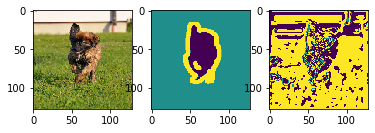

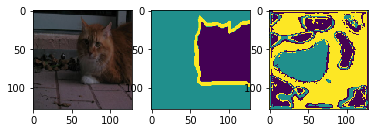

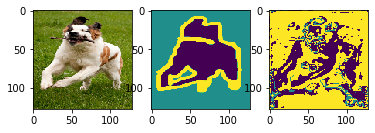

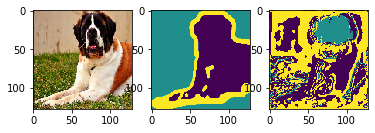

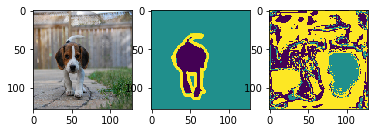

In [60]:
for row in test_sample.take(5):
  image,mask = normalize_data(row)
  plt.imshow(image)
  # y = model.predict(np.reshape(image,(1,128,128,3)))
  plt.subplot(1,3,1)
  plt.imshow(image)

  plt.subplot(1,3,2)
  plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
  # print(mask.shape)
  # plt.subplot(1,3,3)
  # y = np.argmax(y,axis=-1)
  # y = np.reshape(y,(128,128))
  # print(y_.shape)
  # plt.imshow(tf.keras.preprocessing.image.array_to_img(np.expand_dims(y,axis=-1)))
  plt.show()